In [2]:
import os
import numpy as np
import imageio
from imgaug import augmenters as iaa
from imgaug import parameters as iap
from matplotlib import pyplot as plt

from utils.helpers import resize_to_256

In [2]:
crop_aug = iaa.Sometimes(
    0.9,
    iaa.Crop(
        percent=iap.Positive(iap.Normal(0, 0.1)),
        sample_independently=True,
        keep_size=False
    ),
)

# Load random bg from gi

In [3]:
path = './data/images'
filenames = os.listdir(path)
first_file_path = os.path.join(path, filenames[0])
sample_img = imageio.imread(first_file_path, pilmode="RGB")
sample_arr = np.array(sample_img, dtype=np.uint8)

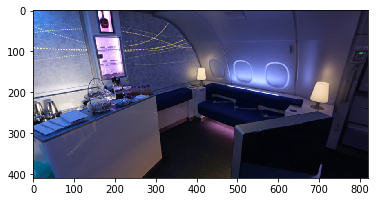

In [4]:
plt.imshow(sample_arr);

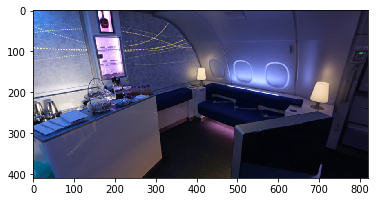

In [5]:
sample_arr_mod = crop_aug.augment_image(sample_arr)
plt.imshow(sample_arr_mod);

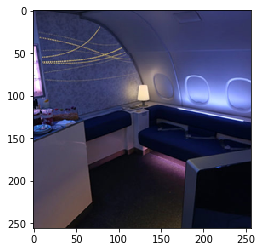

In [6]:
sample_arr_256 = resize_to_256(sample_arr_mod)
plt.imshow(sample_arr_256);

In [7]:
bg = sample_arr_256

# Load original card image

In [24]:
mask_img = imageio.imread('data/train/original_sample_mask_inv_1000.jpg', pilmode="RGB", as_gray=True)
original_mask = np.array(mask_img, dtype=np.uint8)

card_img = imageio.imread('data/train/original_sample_1000.jpg', pilmode="RGB")
original_card = np.array(card_img, dtype=np.uint8)

In [8]:
def show_mask_and_image(mask_img, card_img):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].set_axis_off()
    axes[0].imshow(mask_img);
    axes[1].set_axis_off()
    axes[1].imshow(card_img);

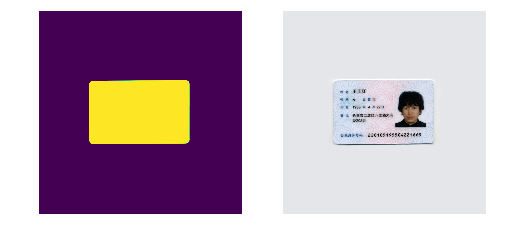

In [25]:
show_mask_and_image(mask_img, card_img)

In [26]:
affine_aug = iaa.Affine(rotate=20, mode='wrap')

rotated_mask = affine_aug.augment_image(original_mask)
rotated_card = affine_aug.augment_image(original_card)

rotated_mask_256 = resize_to_256(rotated_mask)
rotated_card_256 = resize_to_256(rotated_card)

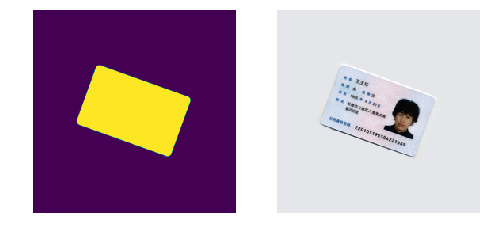

In [27]:
show_mask_and_image(rotated_mask_256, rotated_card_256)

In [9]:
def merge_by_mask(background, foreground, mask):
    w, h, chanells = background.shape
    merg_arr = np.array(background, dtype=np.uint8)
    for i in range(h):
        for j in range(w):
            if mask[i][j] > 100:
                for c in range(chanells):
                    merg_arr[i][j][c] = foreground[i][j][c]
    return merg_arr

In [28]:
test_img = merge_by_mask(bg, rotated_card_256, rotated_mask_256)

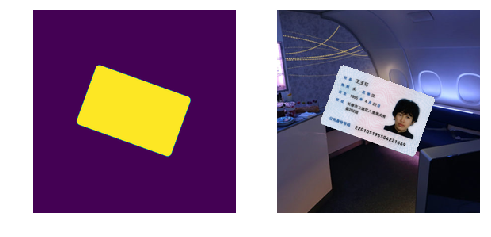

In [29]:
show_mask_and_image(rotated_mask_256, test_img)

# Predict

In [10]:
from utils.unet import get_compiled_model
from utils.helpers import show_predict_mask_above_image

Using TensorFlow backend.


In [11]:
h_size = 256
w_size = 256
start_neurons = 4

In [12]:
model = get_compiled_model(h_size, w_size, start_neurons)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [30]:
model.load_weights('./data/weights/n4/w_n4_003.h5')

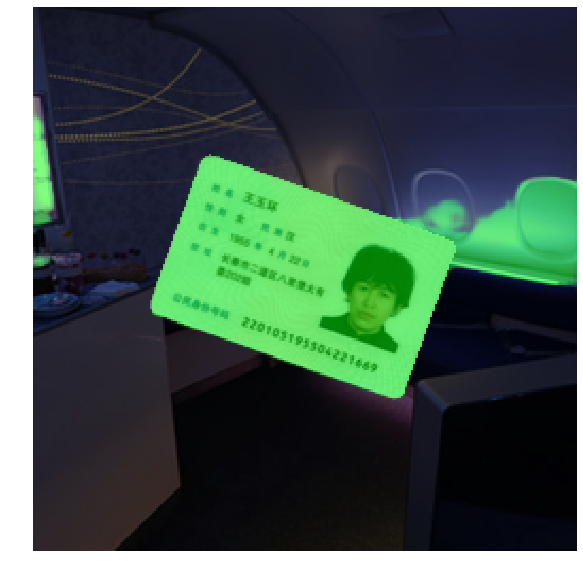

In [31]:
test_arr = np.array(test_img, dtype=np.uint8) / 255.0
show_predict_mask_above_image(test_arr, model, h_size, w_size)

In [32]:
test_x = np.zeros((1, h_size, w_size, 3), dtype='float32')
test_x[0] = test_arr

test_y = model.predict(test_x)
pred_arr = test_y[0]

In [15]:
def get_iou(true_mask: np.ndarray, pred_mask: np.ndarray) -> float:
    t = true_mask/np.max(true_mask)
    p = pred_mask.reshape(true_mask.shape)/np.max(pred_mask)
    true = np.sum(t)
    pred = np.sum(p)
    intersection = np.sum(t * p)
    union = true + pred - intersection
    return intersection / union

In [33]:
get_iou(rotated_mask_256, pred_arr)

0.7732555478583412

# Let's make pipeline

In [16]:
def load_model(h_size, w_size, start_neurons, weights_path):
    model = get_compiled_model(h_size, w_size, start_neurons)
    model.load_weights(weights_path)
    return model

In [34]:
h_size = 256
w_size = 256
start_neurons = 4
weights_path = './data/weights/n4/w_n4_003.h5'

In [35]:
model = load_model(h_size, w_size, start_neurons, weights_path)

In [36]:
def get_predict_mask(img: np.ndarray) -> np.ndarray:
    # prepare
    test_x = np.array(img, dtype='float32') / 255.0
    test_x = np.expand_dims(test_x, axis=0)
    
    # predict
    test_y = model.predict(test_x)
    return test_y.reshape(img.shape[0], img.shape[1], 1)

In [37]:
predict = get_predict_mask(test_img)

In [38]:
get_iou(rotated_mask_256, predict)

0.7732555478583412

In [20]:
import keras

In [21]:
def get_precision(model: keras.engine.training.Model, img: np.ndarray) -> float:
    predict = get_predict_mask(img)
    iou = get_iou(rotated_mask_256, predict)
    return iou

In [39]:
get_precision(model, test_img)

0.7732555478583412

# Iterate by GI images

In [22]:
def get_bg(path, filename):
    first_file_path = os.path.join(path, filename)
    sample_img = imageio.imread(first_file_path, pilmode="RGB")
    sample_arr = np.array(sample_img, dtype=np.uint8)
    sample_arr_mod = sample_arr  # crop_aug.augment_image(sample_arr)
    sample_arr_256 = resize_to_256(sample_arr_mod)
    return sample_arr_256

In [40]:
path = './data/images'
filenames = os.listdir(path)
stat = {}
for filename in filenames:
    try:
        bg = get_bg(path, filename)
    except:
        continue
    test_img = merge_by_mask(bg, rotated_card_256, rotated_mask_256)
    precision = get_precision(model, test_img)
    stat[filename] = precision

/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205651968 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4050555094 bytes but only got 0. Skipping tag 31743
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11779305760 bytes but only got 0. Skipping tag 46335
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 17760258 bytes but only got 11256. Skipping tag 65497
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt E

In [40]:
from typing import List
import multiprocessing as mp
import os
import imageio

def chunks(list_, size):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(list_), size):
        yield list_[i:i + size]

def try_load_images(path_list: str) -> List[str]:
    bad_img_path_list = []
    for path in path_list:
        try:
            imageio.imread(path, pilmode="RGB")
        except:
            bad_img_path_list.append(path)
        else:
            continue
    return bad_img_path_list

def get_all_bad_filenames(dirpath: str) -> List[str]:
    path_list = [
        os.path.join(dirpath, filename)
        for filename in os.listdir(dirpath)
    ]
    path_chunk_list = list(chunks(path_list, 100))
    with mp.Pool(mp.cpu_count()) as p:
        bad_img_path_chunk_list = p.map(try_load_images, path_chunk_list)
    
    return [x for p_list in bad_img_path_chunk_list for x in p_list]

def rm_bad_files_from_gi_images(dirpath: str):
    bad_file_path_list = get_all_bad_filenames(dirpath)
    
    for path in bad_file_path_list:
        os.remove(path)

In [32]:
bad_file_path_list = get_all_bad_filenames('./data/images')

/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205651968 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4050555094 bytes but only got 0. Skipping tag 31743
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11779305760 bytes but only got 0. Skipping tag 46335
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 17760258 bytes but only got 11

/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 196608 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 10332 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 10324 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 10204 bytes but only got 220. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32

In [33]:
bad_file_path_list

['./data/images/54. ?media_id=351097558712638.jpg',
 './data/images/94. sting.jpg',
 './data/images/19. victoria-s-journals-korean-journal-teabook-high-quality-stationery-notebook-fountain-pen-friendly-made-with-spanish.jpg',
 './data/images/80. ?media_id=1567327033362918.jpg',
 './data/images/10. vintage-style-thai-silver-necklace-paragraphs-man-domineering-keel-silver-necklace-thick-silver-necklace-with-exquisite.jpg',
 './data/images/50. northkorea-nuclear-china.jpg',
 './data/images/64. 9780804849401.back__22686.1536585646.jpg',
 './data/images/58. 76fcd104275dd414b6955d05dc3219cd.jpg',
 './data/images/80. ?media_id=106851029353881.jpg',
 './data/images/61. mohamm-japanese-korean-journal-label-diary-small-girl-cute-stickers-scrapbooking-flakes-stationery.jpg',
 './data/images/50. air-ticket-collage-polygonal-mesh-260nw-1243483096.jpg',
 './data/images/51. 9780804849531_back__10783.1521728281.jpg',
 './data/images/28. ?media_id=2474048849347713.jpg',
 './data/images/61. 134884257914

In [36]:
len(os.listdir('./data/images'))

16615

In [37]:
for path in bad_file_path_list:
    os.remove(path)

In [38]:
len(os.listdir('./data/images'))

16210

In [24]:
dirpath = './data/images'
path_list = [
    os.path.join(dirpath, filename)
    for filename in os.listdir(dirpath)
]

In [25]:
path_chunk_list = list(chunks(path_list, 100))

In [26]:
with mp.Pool(mp.cpu_count()) as p:
    good_img_path_chunk_list = p.map(try_load_images, path_chunk_list)

/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205651968 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4050555094 bytes but only got 0. Skipping tag 31743
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11779305760 bytes but only got 0. Skipping tag 46335
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 17760258 bytes but only got 11

/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 196608 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 10332 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 10324 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 10204 bytes but only got 220. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32

In [28]:
good_file_path_list = [x for p_list in good_img_path_chunk_list for x in p_list]

In [30]:
len(os.listdir('./data/images')) - len(good_file_path_list)

405

In [41]:
len(stat)

16210

In [51]:
sum(stat.values()) / len(stat)

0.5767491808695698

In [42]:
sorted_stat = sorted(stat.items(), key=lambda kv: kv[1])

In [43]:
sorted_stat[:10]

[('24. 1182.jpg', 0.14464776372028906),
 ('35. firstpage-s0021911800060381a.jpg', 0.15497179625742208),
 ('2. 6-problems-about-studying-japanese-in-1899-2.jpg', 0.15518152719464626),
 ('4. 6-problems-about-studying-japanese-in-1899-2.jpg', 0.15518152719464626),
 ('6. 20180302_1209351733715607.jpg', 0.15638807007532307),
 ('47. firstpage-s0021911800155275a.jpg', 0.1568795896581856),
 ('89. firstpage-s0021911800137891a.jpg', 0.15872858955648766),
 ('71. 18719732_020_02_s005_i0003.jpg', 0.15899792387859882),
 ('2. depositphotos_141088364-stock-illustration-decorated-border-lines-with-japanese.jpg',
  0.16117248495788505),
 ('65. firstpage-s0021911800156074a.jpg', 0.16154000064306798)]

In [44]:
sorted_stat[-10:]

[('25. 31b6avfkkfl._sx321_bo1,204,203,200_.jpg', 0.9822773178965842),
 ('32. e22-engine-chinese-manuals-wiring-diagram-0-01-amazing-atv-diagrams-250cc.jpg',
  0.9823248788937325),
 ('5. 9781138758049.jpg', 0.9823571533857394),
 ('80. mang-grnmos-2__11747.1440544504.500.659.jpg', 0.9823633987595817),
 ('84. opposite-lines-817.jpg', 0.9823929389913483),
 ('35. md22555924065.jpg', 0.9824288266262584),
 ('62. chinese-letters-mens-t-shirt.jpg', 0.9824289444790144),
 ('84. 38929d1242777841-ww2-ijn-japanese-personal-effects-bag-contents-dsc01977.jpg',
  0.9824984481300558),
 ('50. hanji-category.jpg', 0.9825764222349247),
 ('87. 1478496833_one_cover.jpg', 0.982867747874349)]

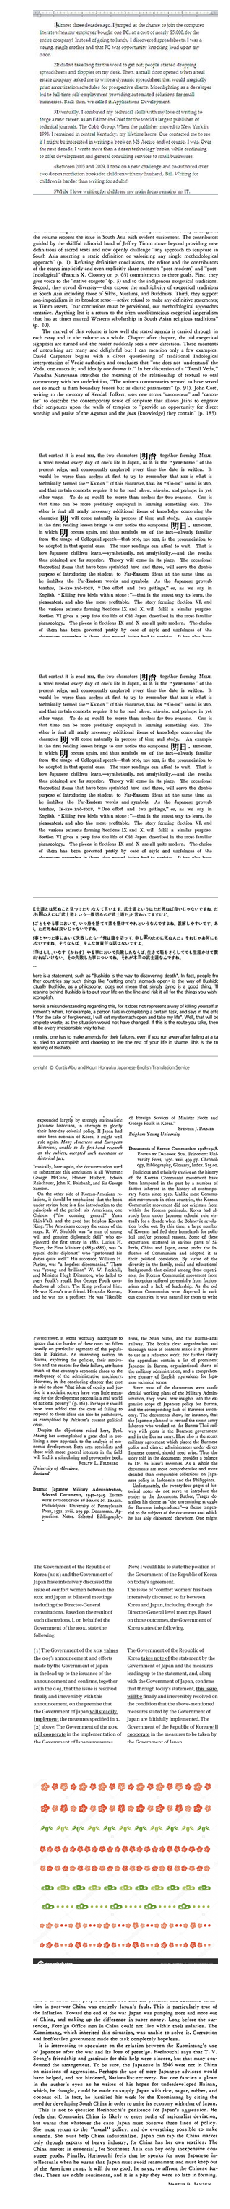

In [45]:
fig, axes = plt.subplots(10, 1, figsize=(4, 40))
i = 0
for filename, p in sorted_stat[:10]:
    bg = get_bg(path, filename)
    axes[i].set_axis_off()
    axes[i].imshow(bg)
    i += 1

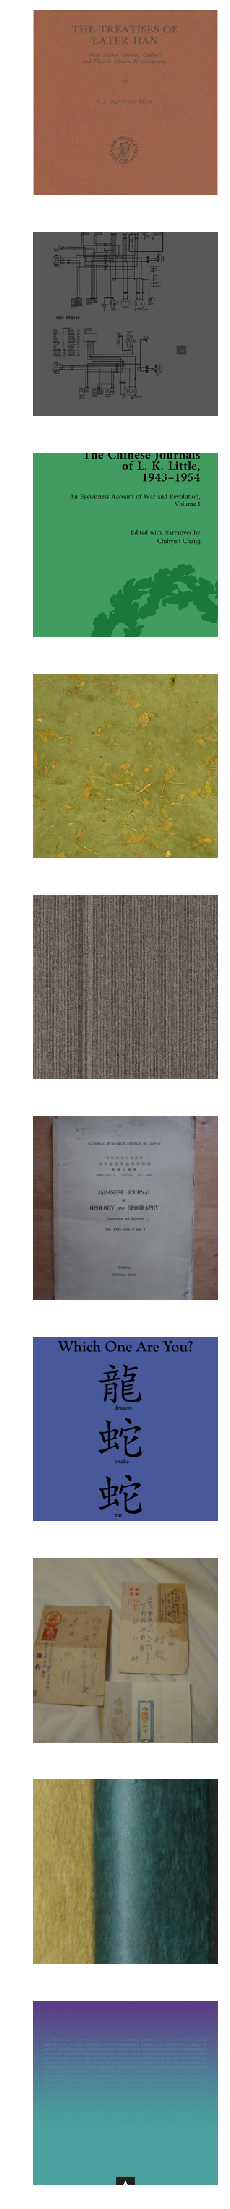

In [47]:
fig, axes = plt.subplots(10, 1, figsize=(4, 40))
i = 0
res = []
for filename, p in sorted_stat[-10:]:
#     print(filename)
    bg = get_bg(path, filename)
#     res.append(np.sum(bg))
    axes[i].set_axis_off()
    axes[i].imshow(bg)
    i += 1

In [114]:
sorted_stat

[('4. firstpage-s0021911800044831a.jpg', 0.17574522595881256),
 ('1. fltr-1.jpg', 0.182289506952451),
 ('5. fltr-1.jpg', 0.182289506952451),
 ('5. shutterstock_193652336-1200x799.jpg', 0.2109709216731045),
 ('1. 1102.jpg', 0.2222966328436942),
 ('4. cover_issue_10547_en_us.jpg', 0.2533132428476209),
 ('2. dp2v9tty-1381627354.jpg', 0.25366068515618484),
 ('5. c369e156271c0e36ca51c8bd4da6bd97.jpg', 0.25450800440850874),
 ('3. 14006572571400669023l.jpg', 0.25744314678338565),
 ('1. 14006572571400669023l.jpg', 0.25744314678338565),
 ('4. _103519717_letter1.jpg', 0.26833333200377507),
 ('1. c1_1148912_620x413.jpg', 0.2696261115914339),
 ('5. thenation.jpg', 0.28478251362152635),
 ('4. thenation.jpg', 0.28478251362152635),
 ('2. 121120khaosod.jpg', 0.28801356947994544),
 ('3. 121120khaosod.jpg', 0.28801356947994544),
 ('4. fa79fbc29881431ea6fb265c4375a3af.jpg', 0.2905834858211515),
 ('5. guangzhou-guangdong-province-china-chinese-newspapers-in-city-of-guangzhou-c9badd.jpg',
  0.2950773938260